In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_1.csv")


In [9]:
dataFrame = pd.read_csv(resultsPath)

dataFrame["problemSize"] = dataFrame["problemSize"].astype(int)
dataFrame["numThreads"] = dataFrame["numThreads"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Problem sizes:", sorted(dataFrame["problemSize"].unique()))
print("Thread counts:", sorted(dataFrame["numThreads"].unique()))
dataFrame.head(8)


Loaded rows: 350
Modes: ['reduction' 'no_reduction']
Problem sizes: [1000000, 5000000, 10000000, 50000000, 100000000]
Thread counts: [1, 2, 4, 6, 8, 16, 32]


,testType,problemSize,numThreads,mode,timeSeconds,minValue,runIndex,ompEnv
0,OpenMP_1,1000000,1,reduction,0.000172,736,1,OMP_NUM_THREADS=1
1,OpenMP_1,1000000,1,reduction,0.000183,4525,2,OMP_NUM_THREADS=1
2,OpenMP_1,1000000,1,reduction,0.000170,168,3,OMP_NUM_THREADS=1
3,OpenMP_1,1000000,1,reduction,0.000174,297,4,OMP_NUM_THREADS=1
4,OpenMP_1,1000000,1,reduction,0.000185,1567,5,OMP_NUM_THREADS=1
5,OpenMP_1,1000000,2,reduction,0.000223,2984,1,OMP_NUM_THREADS=2
6,OpenMP_1,1000000,2,reduction,0.000220,1846,2,OMP_NUM_THREADS=2
7,OpenMP_1,1000000,2,reduction,0.000209,710,3,OMP_NUM_THREADS=2


In [10]:
groupedFrame = dataFrame.groupby(["mode","problemSize","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)

groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","problemSize","numThreads"]).reset_index(drop=True)
groupedFrame.head(12)

,mode,problemSize,numThreads,median,mean,std,count
0,no_reduction,1000000,1,0.000171,0.000171,0.000002,5
1,no_reduction,1000000,2,0.000228,0.000232,0.000020,5
2,no_reduction,1000000,4,0.000260,0.000266,0.000023,5
3,no_reduction,1000000,6,0.000332,0.000316,0.000025,5
4,no_reduction,1000000,8,0.000363,0.000371,0.000019,5
5,no_reduction,1000000,16,0.000628,0.000618,0.000019,5
6,no_reduction,1000000,32,0.001121,0.001136,0.000049,5
7,no_reduction,5000000,1,0.000806,0.000807,0.000010,5
8,no_reduction,5000000,2,0.000632,0.000664,0.000065,5
9,no_reduction,5000000,4,0.000565,0.000557,0.000019,5


In [11]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, problemSizeVal), subFrame in groupedDf.groupby(["mode","problemSize"]):
        baseRows = subFrame[subFrame["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numThreads"]
        frames.append(subFrame)
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,mode,problemSize,numThreads,median,mean,std,count,speedup,efficiency
0,no_reduction,1000000,1,0.000171,0.000171,0.000002,5,1.000000,1.000000
1,no_reduction,1000000,2,0.000228,0.000232,0.000020,5,0.750548,0.375274
2,no_reduction,1000000,4,0.000260,0.000266,0.000023,5,0.659730,0.164933
3,no_reduction,1000000,6,0.000332,0.000316,0.000025,5,0.516285,0.086047
4,no_reduction,1000000,8,0.000363,0.000371,0.000019,5,0.471625,0.058953
5,no_reduction,1000000,16,0.000628,0.000618,0.000019,5,0.272829,0.017052
6,no_reduction,1000000,32,0.001121,0.001136,0.000049,5,0.152748,0.004773
7,no_reduction,5000000,1,0.000806,0.000807,0.000010,5,1.000000,1.000000
8,no_reduction,5000000,2,0.000632,0.000664,0.000065,5,1.274956,0.637478
9,no_reduction,5000000,4,0.000565,0.000557,0.000019,5,1.426624,0.356656


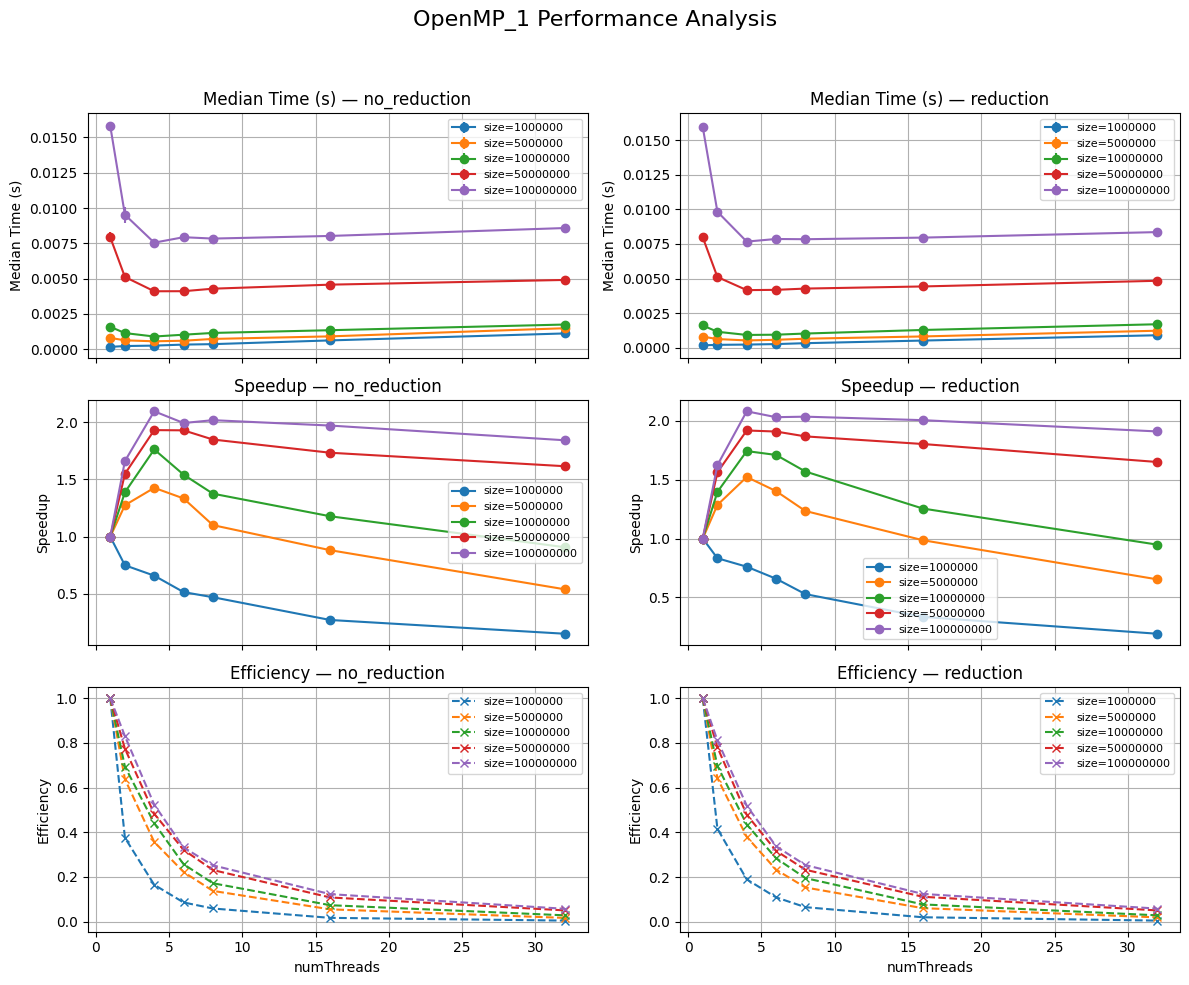

In [12]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {
    "median": "Median Time (s)",
    "speedup": "Speedup",
    "efficiency": "Efficiency"
}

fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        axIdx = rowIdx*2 + colIdx
        ax = axes[axIdx]
        
        for problemSizeVal in sorted(perfFrame["problemSize"].unique()):
            subFrame = perfFrame[(perfFrame["mode"]==modeVal) & (perfFrame["problemSize"]==problemSizeVal)].sort_values("numThreads")
            if subFrame.empty:
                continue
            x = subFrame["numThreads"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"size={problemSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"size={problemSizeVal}")

        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == 2:
            ax.set_xlabel("numThreads")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle("OpenMP_1 Performance Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [13]:
for modeVal in perfFrame["mode"].unique():
    pivotTime = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="problemSize", values="median")
    pivotSpeedup = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="problemSize", values="speedup")
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(pivotTime)
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(pivotSpeedup)



=== mode: no_reduction — median time (s) ===


problemSize,1000000,5000000,10000000,50000000,100000000
numThreads,,,,,
1,0.000171,0.000806,0.001590,0.007928,0.015810
2,0.000228,0.000632,0.001146,0.005120,0.009522
4,0.000260,0.000565,0.000903,0.004107,0.007548
6,0.000332,0.000604,0.001032,0.004111,0.007934
8,0.000363,0.000732,0.001156,0.004289,0.007837
16,0.000628,0.000914,0.001350,0.004575,0.008024
32,0.001121,0.001490,0.001751,0.004908,0.008583



=== mode: no_reduction — speedup ===


problemSize,1000000,5000000,10000000,50000000,100000000
numThreads,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.750548,1.274956,1.387871,1.548637,1.660292
4,0.659730,1.426624,1.761546,1.930554,2.094707
6,0.516285,1.334051,1.541780,1.928676,1.992614
8,0.471625,1.101107,1.375627,1.848413,2.017302
16,0.272829,0.882211,1.178410,1.733059,1.970339
32,0.152748,0.540764,0.908182,1.615403,1.842011



=== mode: reduction — median time (s) ===


problemSize,1000000,5000000,10000000,50000000,100000000
numThreads,,,,,
1,0.000174,0.000804,0.001610,0.007980,0.015948
2,0.000209,0.000626,0.001154,0.005111,0.009829
4,0.000228,0.000528,0.000924,0.004164,0.007672
6,0.000264,0.000574,0.000942,0.004184,0.007860
8,0.000329,0.000652,0.001026,0.004276,0.007843
16,0.000518,0.000816,0.001283,0.004429,0.007959
32,0.000903,0.001230,0.001698,0.004839,0.008358



=== mode: reduction — speedup ===


problemSize,1000000,5000000,10000000,50000000,100000000
numThreads,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.832774,1.284870,1.395319,1.561240,1.622648
4,0.760946,1.521665,1.741506,1.916260,2.078754
6,0.659082,1.402022,1.708780,1.907283,2.028981
8,0.528428,1.233436,1.568255,1.866070,2.033405
16,0.335456,0.985902,1.254482,1.801608,2.003744
32,0.192512,0.653768,0.948047,1.648998,1.908113


In [14]:
summaryRows = []
for (modeVal, problemSizeVal), sub in perfFrame.groupby(["mode","problemSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "problemSize": problemSizeVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })

summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","problemSize"])
display(summaryAnalysisFrame)


,mode,problemSize,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,no_reduction,1000000,1,1.000000,1.000000,0.000171
1,no_reduction,5000000,4,1.426624,0.356656,0.000806
2,no_reduction,10000000,4,1.761546,0.440387,0.001590
3,no_reduction,50000000,4,1.930554,0.482639,0.007928
4,no_reduction,100000000,4,2.094707,0.523677,0.015810
5,reduction,1000000,1,1.000000,1.000000,0.000174
6,reduction,5000000,4,1.521665,0.380416,0.000804
7,reduction,10000000,4,1.741506,0.435377,0.001610
8,reduction,50000000,4,1.916260,0.479065,0.007980
9,reduction,100000000,4,2.078754,0.519688,0.015948
